# Introducción a las máquinas de soporte vectorial

El Maximal Margin Classifier descrito en la sección anterior tiene poca aplicación práctica, ya que rara vez se encuentran casos en los que las clases sean perfecta y linealmente separables. De hecho, incluso cumpliéndose estas condiciones ideales, en las que exista un hiperplano capaz de separar perfectamente las observaciones en dos clases, esta aproximación sigue presentando dos inconvenientes:

- Dado que el hiperplano tiene que separar perfectamente las observaciones, es muy sensible a variaciones en los datos. Incluir una nueva observación puede suponer cambios muy grandes en el hiperplano de separación (poca robustez).

- Que el maximal margin hyperplane se ajuste perfectamente a las observaciones de entrenamiento para separarlas todas correctamente suele conllevar problemas de overfitting.

Por estas razones, es preferible crear un clasificador basado en un hiperplano que, aunque no separe perfectamente las dos clases, sea más robusto y tenga mayor capacidad predictiva al aplicarlo a nuevas observaciones (menos problemas de overfitting).

Esto es exactamente lo que consiguen los clasificadores de vector soporte, también conocidos como soft margin classifiers o Support Vector Classifiers. Para lograrlo, en lugar de buscar el margen de clasificación más ancho posible que consigue que las observaciones estén en el lado correcto del margen; se permite que ciertas observaciones estén en el lado incorrecto del margen o incluso del hiperplano.

La identificación del hiperplano de un clasificador de vector soporte, que clasifique correctamente la mayoría de las observaciones a excepción de unas pocas, es un problema de optimización convexa.

Si bien la demostración matemática queda fuera del objetivo de esta introducción, es importante mencionar que el proceso incluye un hiperparámetro de tuning C, donde controla el número y severidad de las violaciones del margen (y del hiperplano) que se toleran en el proceso de ajuste. Si C tiende al infinito no se permite ninguna violación del margen y por lo tanto, el resultado es equivalente al Maximal Margin Classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets

#Importacion de un solo flujo de datos
from sklearn.pipeline import Pipeline

# El SVM es sensible a datos no escalados
from sklearn.preprocessing import StandardScaler

In [3]:
iris = datasets.load_iris()
X = iris['data'][:, (2, 3)]
y = (iris.target == 2) #setosa #

In [4]:
from sklearn.base import BaseEstimator

class MyLinearEstimator(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000,
                 random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1)  # n feature weights
        b = 0

        t = np.array(y, dtype=np.float64).reshape(-1, 1) * 2 - 1
        X_t = X * t
        self.Js = []

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * (w * w).sum() + self.C * (((1 - X_t_sv.dot(w)) - b * t_sv).sum())
            self.Js.append(J)

            w_gradient_vector = w - self.C * X_t_sv.sum(axis=0).reshape(-1, 1)
            b_derivative = -self.C * t_sv.sum()
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b <= 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return self.decision_function(X) >= 0

In [5]:

#svm_clf = MyLinearStimator(C=2, eta0 = 1, eta_d = 1000,
#                      random_state=42)
svm_clf = MyLinearEstimator(C=2, eta0 = 10, eta_d = 1000,
                      random_state=42)
svm_clf.fit(X, y)

MyLinearEstimator(C=2, eta0=10, eta_d=1000, random_state=42)

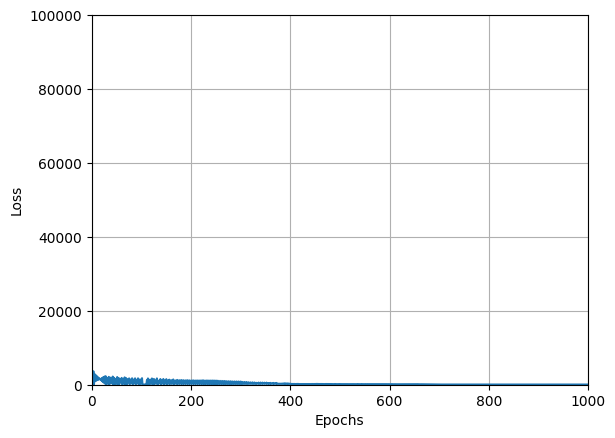

In [14]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100000])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [7]:
print(svm_clf.intercept_, svm_clf.coef_)

[-35.45060808] [[[6.04368845]
  [3.81403543]]]


In [8]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]

    #---Para la clase se definieron las variables
    #---upper y lower por gutter_up y gutter_down, respectivamente
    upper = decision_boundary + margin
    lower = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, upper, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, lower, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

In [9]:
from sklearn.svm import SVC

C = 2
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


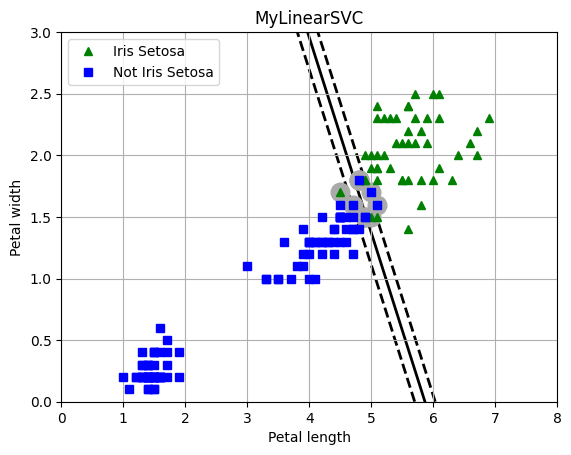

In [10]:
yr = y.ravel()
#fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris Setosa")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris Setosa")
plot_svc_decision_boundary(svm_clf, 0, 8)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title("MyLinearSVC")
plt.axis([0, 8, 0, 3])
plt.legend(loc="upper left")
plt.grid()

plt.show()

In [11]:
print(svm_clf.support_vectors_)

[[4.9 1.5]
 [4.7 1.6]
 [4.8 1.8]
 [4.9 1.5]
 [5.  1.7]
 [5.1 1.6]
 [4.5 1.7]
 [5.  1.5]
 [4.8 1.8]
 [4.8 1.8]]


In [12]:
print(svm_clf.predict(np.array([[1.5, 0.25],[1.5, 1]])))

[[False]
 [False]]
